In [ ]:
import tensorflow as tf

In [ ]:
import glob
import imageio
import matplotlib.pyplot as plt
import os
import PIL
from tensorflow.keras import layers 
import time
from tqdm import tqdm
from IPython import display

In [ ]:
(train_images,train_labels),(_,_)=tf.keras.datasets.mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
train_images=train_images.reshape(train_images.shape[0],28,28,1).astype('float32')
train_images=(train_images-127.5)/127.5

In [ ]:
len(train_images)

60000

In [ ]:
BUFFER_SIZE=60000
BATCH_SIZE=256

In [ ]:
train_dataset=tf.data.Dataset.from_tensor_slices(train_images)
train_dataset=train_dataset.shuffle(BUFFER_SIZE)
train_dataset=train_dataset.batch(BATCH_SIZE) 


In [ ]:
def make_generator():
  model=tf.keras.Sequential()
  model.add(layers.Dense(7*7*256 , use_bias=False, input_shape=(100,)))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Reshape((7,7,256)))
  assert model.output_shape==(None,7,7,256)

  model.add(layers.Conv2DTranspose(128,(5,5),strides=(1,1),padding='same',use_bias=False))
  assert model.output_shape==(None,7,7,128)

  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())


  model.add(layers.Conv2DTranspose(64,(5,5),strides=(2,2),padding='same',use_bias=False))
  assert model.output_shape==(None,14,14,64)

  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(1  ,(5,5),strides=(2,2),padding='same',use_bias=False, activation='tanh'))
  assert model.output_shape==(None,28,28,1)

  return model

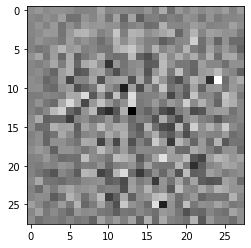

In [ ]:
generator=make_generator()

noise=tf.random.normal([1,100])
generated_image=generator(noise,training=False)

plt.imshow(generated_image[0,:,:,0],cmap='gray')

In [ ]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 batch_normalization (BatchN  (None, 12544)            50176     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 128)        5

In [ ]:
def make_discriminator():
  model=tf.keras.Sequential()
  model.add(layers.Conv2D(64,(5,5),strides=(2,2),padding='same',input_shape=[28,28,1]))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))
  model.add(layers.Conv2D(128,(5,5),strides=(2,2),padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Flatten())
  model.add(layers.Dense(1,activation='sigmoid'))

  return model

In [ ]:
discriminator=make_discriminator()
decision=discriminator(generated_image)
print(decision)

tf.Tensor([[0.49972138]], shape=(1, 1), dtype=float32)


In [ ]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)             

In [ ]:
cross_entropy=tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def disc_loss(real_output,fake_output):
  real_loss=cross_entropy(tf.ones_like(real_output),real_output)
  fake_loss=cross_entropy(tf.zeros_like(fake_output),fake_output)
  return real_loss+fake_loss

In [ ]:
def gen_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output),fake_output)

In [ ]:
generator_optimizer=tf.keras.optimizers.Adam(1e-4)
disc_optimizer=tf.keras.optimizers.Adam(1e-4)

In [ ]:
checkpoint_dir='./training_checkpoints'
checkpoint_prefix=os.path.join(checkpoint_dir,"ckpt")
checkpoint=tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                               discriminator_optimizer=disc_optimizer,
                               generator=generator,
                               discriminator=discriminator)

In [ ]:
EPOCHS=50
noise_dim=100
num_examples_to_generate=16
seed=tf.random.normal([num_examples_to_generate,noise_dim])

In [ ]:
@tf.function
def train_step(images):
  noise =tf.random.normal([BATCH_SIZE, noise_dim])
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images=generator(noise,training=True)

    real_output=discriminator(images,training=True)
    fake_output=discriminator(generated_images,training=True)

    g_loss=gen_loss(fake_output)
    d_loss=disc_loss(real_output,fake_output)
  
  gradients_of_gen=gen_tape.gradient(g_loss,generator.trainable_variables)
  gradients_of_disc=disc_tape.gradient(d_loss,discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip( gradients_of_gen,generator.trainable_variables))
  disc_optimizer.apply_gradients(zip( gradients_of_disc,discriminator.trainable_variables))



In [ ]:
def train(dataset,epochs):
  for epoch in range(epochs):
    start=time.time()
    for image_batch in tqdm(dataset):
      train_step(image_batch)

    display.clear_output(wait=True) 
    generate_and_save_images(generator,
                        epoch+1,
                        seed)
    if (epoch+1)%15==0:
      checkpoint.save(file_prefix=checkpoint_prefix)

    print('Time for epoch {} is {} sec'.format(epoch+1,time.time()-start))

  display.clear_output(wait=True)
  generate_and_save_images(generator,epochs,seed)


In [ ]:
def generate_and_save_images(model,epoch,test_input):
  predictions=model(test_input,training=False)
  fig=plt.figure(figsize=(8,8))

  for i in range(predictions.shape[0]):
    plt.subplot(4,4,i+1)
    plt.imshow(predictions[i,:,:,0]*127.5+127.5,cmap='gray')
    plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

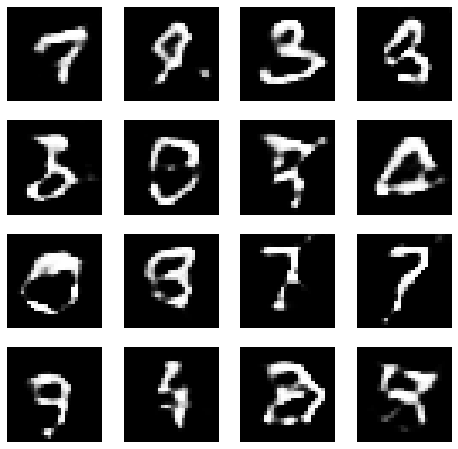

In [ ]:
train(train_dataset,EPOCHS)